# Hourly Energy Consumption Forecast (Part 1/2)

## 1. Hourly Time Series Forecasting using Facebook's Prophet

### 1.1. Data pre-processing


In [1]:
# importing libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# defining style-sheet
plt.style.use('ggplot')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


The data we are using comes from PJM, a TSO from the USA. It is part of the Eastern interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Penssylvania, Tennesee, Virgina, West Virginia and the District of Columbia. 

Data comes from PJM's website and the format is in Megawatts (MW).

We will read data from 2002-2012 in an hourly basis

In [2]:
import os

In [3]:
os.getcwd()

'C:\\Users\\Ingrid - CITCEA\\Documents\\Ironhack_Data_Science_Workshop\\Ironhack_Data_Science_Workshop2019\\Energy_forecast'

In [4]:
dataset = pd.read_csv('./hourly-energy-consumption/PJME_hourly.csv', index_col = [0], parse_dates = [0])

In [5]:
dataset.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


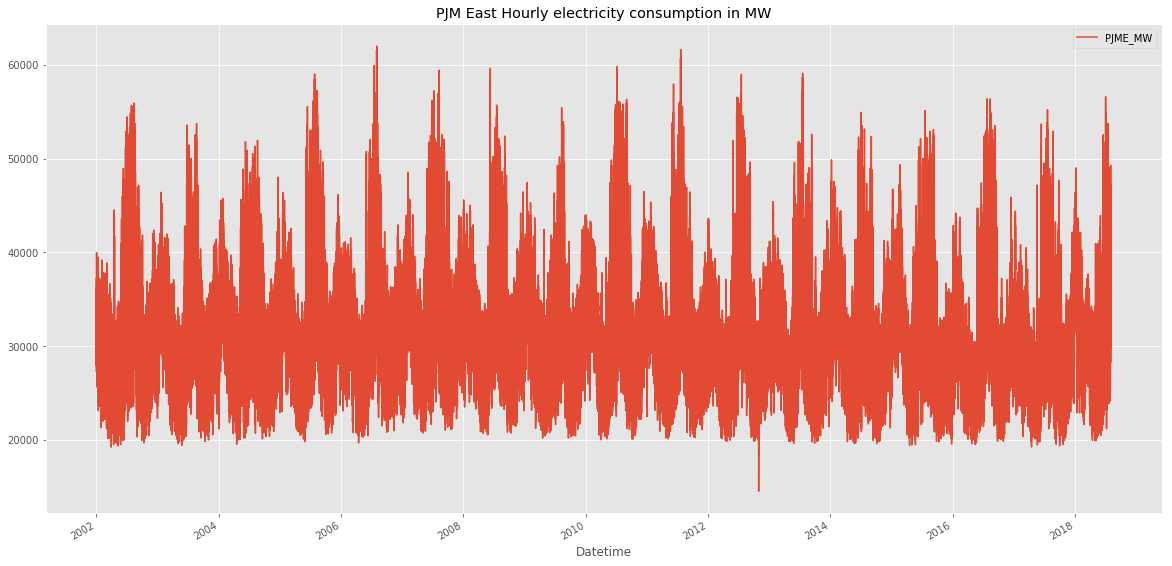

In [6]:
dataset.plot(figsize=(20,10), title='PJM East Hourly electricity consumption in MW')

### 1.2 Exploratory Data Analysis (EDA)

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
X, y = create_features(dataset, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [9]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


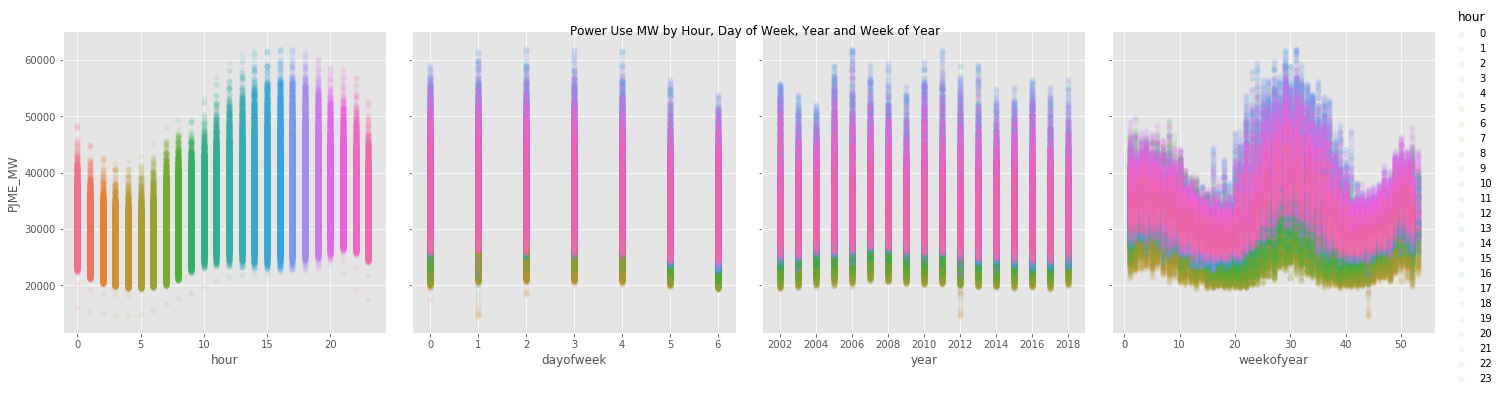

In [10]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

### 1.3 Train/Test Split

We will use data after 2015 as our **TEST** set

In [11]:
split_date = '01-Jan-2015'
dataset_train = dataset.loc[dataset.index <= split_date].copy()
dataset_test = dataset.loc[dataset.index > split_date].copy()

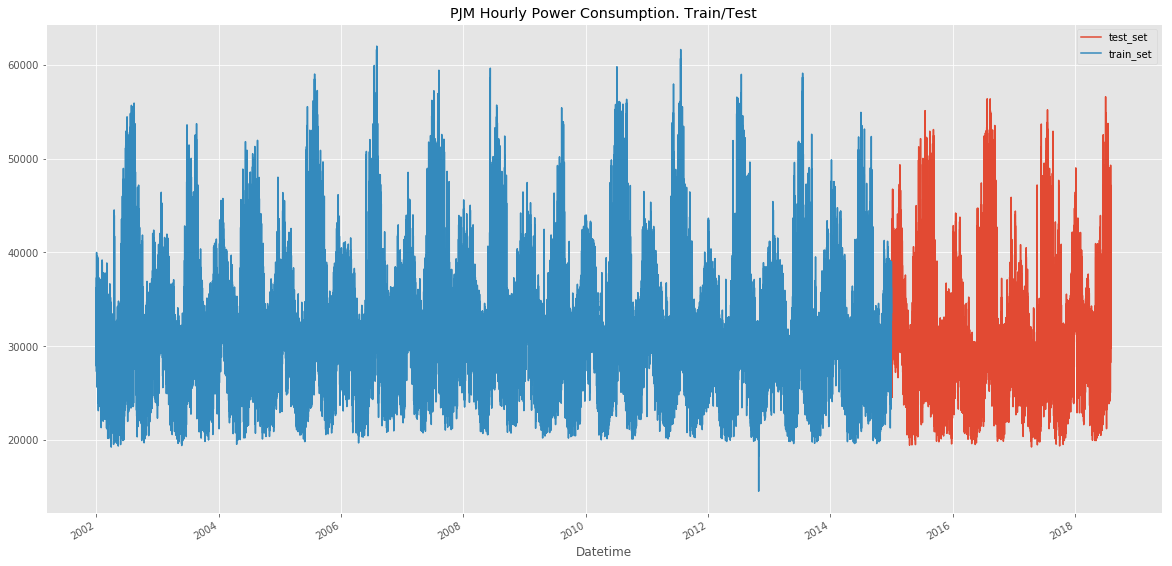

In [12]:
dataset_test.rename(columns={'PJME_MW': 'test_set'})\
.join(dataset_train.rename(columns={'PJME_MW':'train_set'}), how='outer')\
.plot(figsize=(20,10), title = 'PJM Hourly Power Consumption. Train/Test')


### 1.4 Facebook Prophet Model: Simple Model

In [13]:
# Format data for prophet model using ds and y
df_train_prophet = dataset_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})



In [14]:
df_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [15]:
# Setup and train model
model = Prophet()
model.fit(df_train_prophet)

In [25]:
# Format data for prophet model using ds and y. TEST SET
df_test_prophet = dataset_test.reset_index().rename(columns={'Datetime':'ds'})

In [24]:
# Format data for prophet model using ds and y. TEST SET
df_test_prophet = dataset_test.reset_index().rename(columns={'Datetime':'ds'})

# Predict on test set with model
df_test_fcst = model.predict(df=df_test_prophet)

NameError: name 'model' is not defined

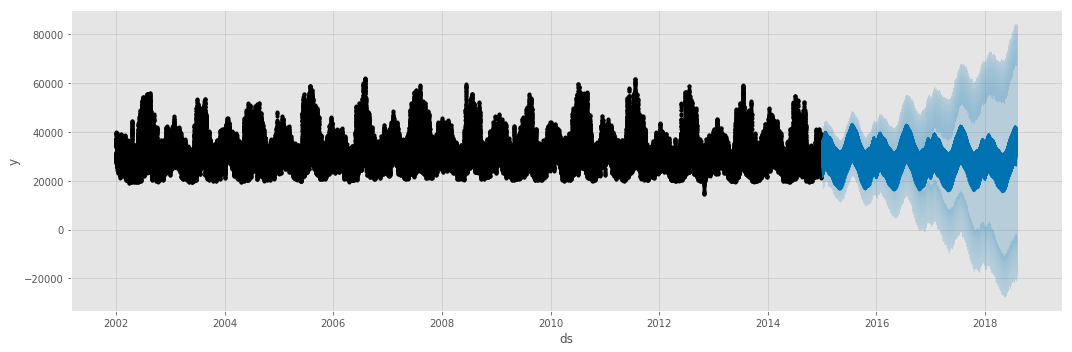

In [18]:
# Plot the forecast
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
prophet_model = model.plot(df_test_fcst, ax=ax)



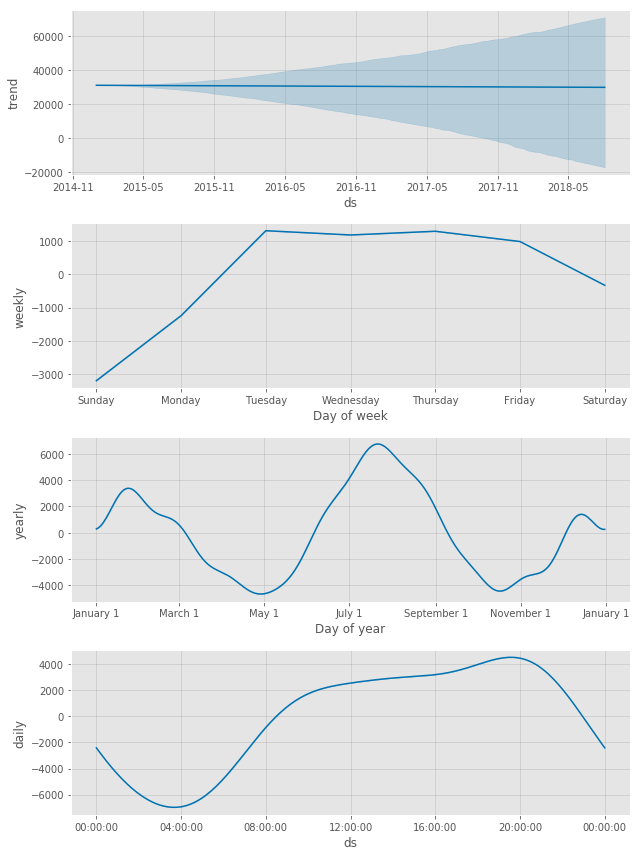

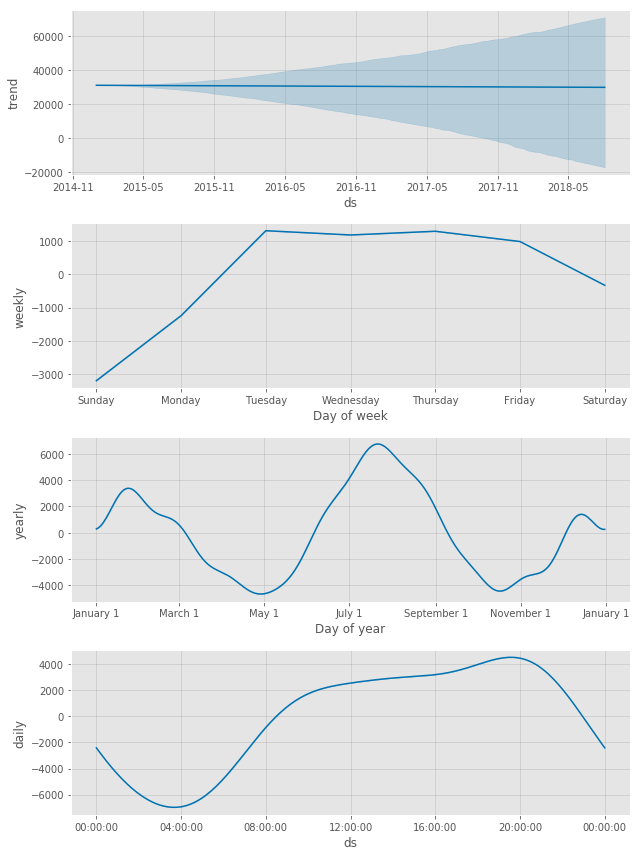

In [19]:
model.plot_components(df_test_fcst)

### 1.4.1 Comparing forecasts to actual value

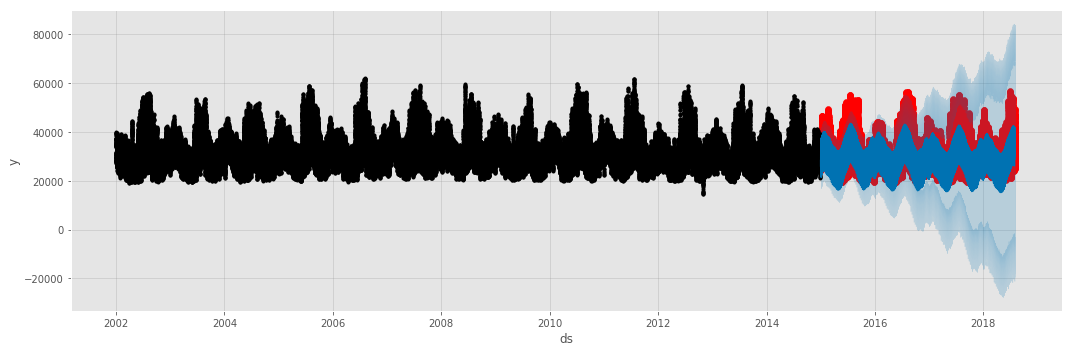

In [20]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
ax.scatter(dataset_test.index, dataset_test['PJME_MW'], color='r')
fig = model.plot(df_test_fcst, ax=ax)



### 1.4.2 Looking at first month of predictions


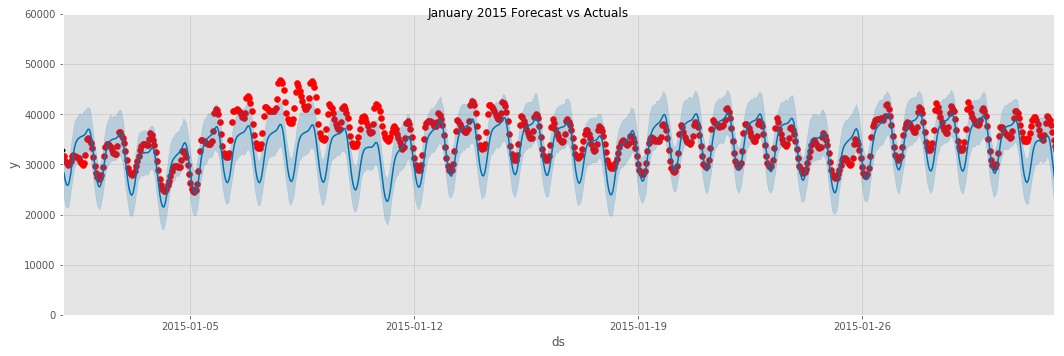

In [50]:
import datetime
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataset_test.index, dataset_test['PJME_MW'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
#ax.set_xbound(lower='01-01-2015 00:00:00', upper='02-01-2015 00:00:00')
#ax.set_xlim(dataset_test.index, dataset_test.index)
ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 2, 1)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### 1.4.3 Single week of predictions

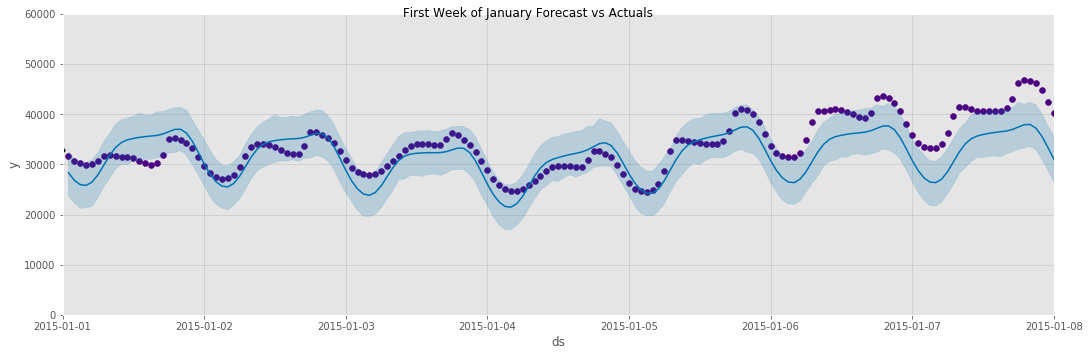

In [53]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataset_test.index, dataset_test['PJME_MW'], color='indigo')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 1, 8)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

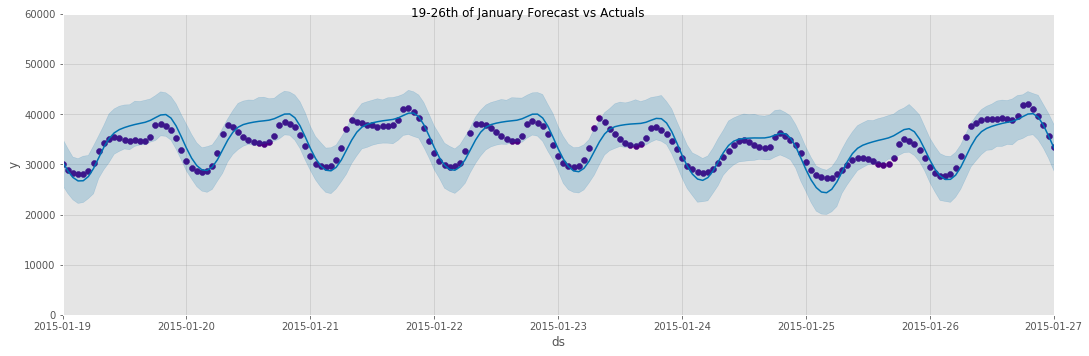

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataset_test.index, dataset_test['PJME_MW'], color='indigo')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xlim([datetime.date(2015, 1, 19), datetime.date(2015, 1, 27)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('19-26th of January Forecast vs Actuals')

### 1.4.5 Error metrics

We have chosen as error metrics: 

- RMSE
- MAE
- MAPE


In [55]:
# RMSE (Root mean squared error)

mean_squared_error(y_true=dataset_test['PJME_MW'], y_pred=df_test_fcst['yhat'])

43851072.27957164

In [56]:
# MAE (Mean Absolute Error)

mean_absolute_error(y_true=dataset_test['PJME_MW'], y_pred=df_test_fcst['yhat'])

5184.220663008904

In [57]:
# MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=dataset_test['PJME_MW'],
                   y_pred=df_test_fcst['yhat'])

16.507248142895172

### 1.5 Facebook Prophet Model: Adding Holidays

Let's see if adding holidays indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training it.

Pandas has a built-in method called `USFederalHolidayCalendar` to pull the list of holidays

In [13]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [20]:
# create calendar object
cal = calendar()
train_holidays = cal.holidays(start=dataset_train.index.min(), end=dataset_train.index.max())
test_holidays = cal.holidays(start=dataset_test.index.min(), end=dataset_test.index.max())

In [21]:
# Create a dataframe with holiday, ds columns
dataset['date'] = dataset.index.date
dataset['is_holiday'] = dataset.date.isin([d.date() for d in cal.holidays()])
holiday_df = dataset.loc[dataset['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [22]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(dataset_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

In [26]:
# Predict on test set with model
df_test_fcst_holidays = model_with_holidays.predict(df=df_test_prophet)

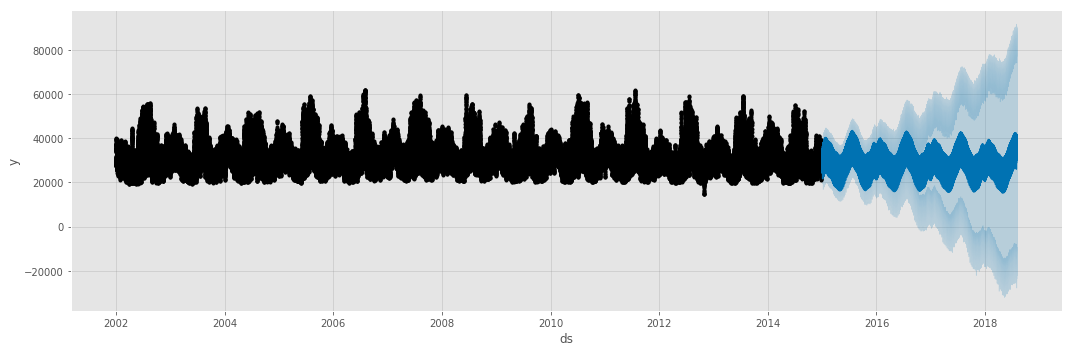

In [28]:
# Plot the forecast
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
prophet_model = model_with_holidays.plot(df_test_fcst_holidays, ax=ax)

### 1.5.1 Plot holiday effect 

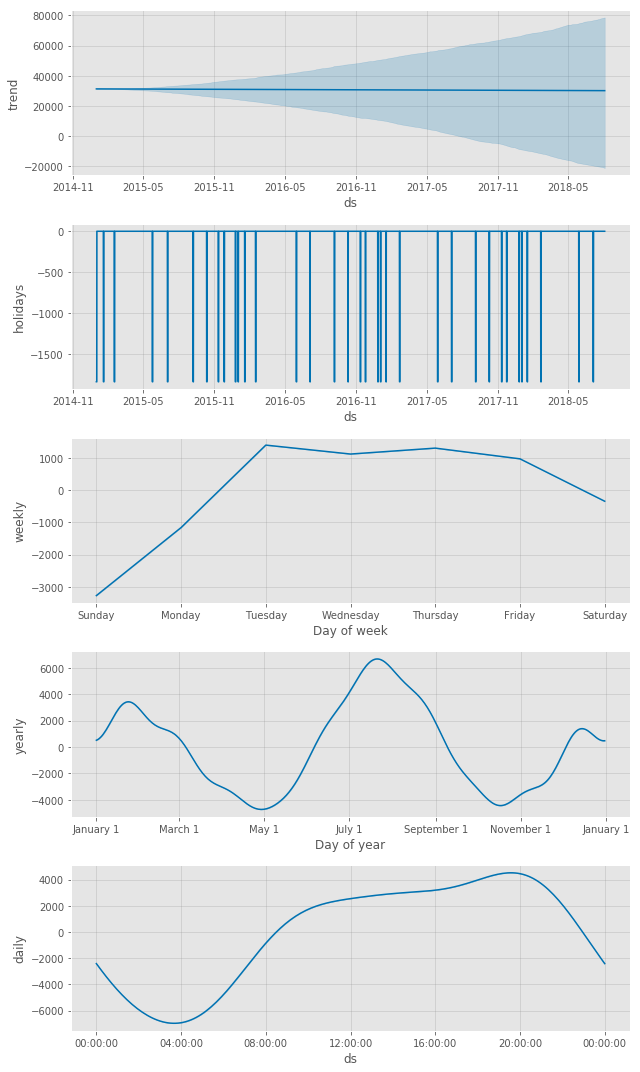

In [29]:
fig_holiday = model_with_holidays.plot_components(df_test_fcst_holidays)

### 1.5.2 Predict with Holidays

In [30]:
df_test_fcst_holidays.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31266.704538,22321.890223,31284.894029,31266.704538,31266.704538,-1836.961889,-1836.961889,-1836.961889,-4480.732528,...,1292.775359,1292.775359,1292.775359,493.828515,493.828515,493.828515,0.0,0.0,0.0,26785.972010
1,2015-01-01 02:00:00,31266.667664,20714.317527,29492.757000,31266.667664,31266.667664,-1836.961889,-1836.961889,-1836.961889,-5984.162032,...,1284.988772,1284.988772,1284.988772,495.175442,495.175442,495.175442,0.0,0.0,0.0,25282.505632
2,2015-01-01 03:00:00,31266.630790,19887.032531,28863.568051,31266.630790,31266.630790,-1836.961889,-1836.961889,-1836.961889,-6855.192447,...,1275.639401,1275.639401,1275.639401,496.560050,496.560050,496.560050,0.0,0.0,0.0,24411.438344
3,2015-01-01 04:00:00,31266.593916,19838.598086,28471.492630,31266.593916,31266.593916,-1836.961889,-1836.961889,-1836.961889,-6996.341081,...,1264.860462,1264.860462,1264.860462,497.982364,497.982364,497.982364,0.0,0.0,0.0,24270.252835
4,2015-01-01 05:00:00,31266.557042,20841.998216,29675.278901,31266.557042,31266.557042,-1836.961889,-1836.961889,-1836.961889,-6321.917416,...,1252.801907,1252.801907,1252.801907,499.442413,499.442413,499.442413,0.0,0.0,0.0,24944.639627


In [31]:
# RMSE (Root mean squared error)

mean_squared_error(y_true=dataset_test['PJME_MW'], y_pred=df_test_fcst_holidays['yhat'])

43857517.726559676

In [32]:
# MAE (Mean Absolute Error)

mean_absolute_error(y_true=dataset_test['PJME_MW'], y_pred=df_test_fcst_holidays['yhat'])

5189.6529880418875

In [34]:
# MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=dataset_test['PJME_MW'], y_pred=df_test_fcst_holidays['yhat'])

16.53992495567091

Even if we try to include and model the holidays inside the time series, the error doesn't improve. This can be because the model needs to be better trained using a different model and modeling holidays differently. 